In [1]:
import numpy as np 
import pandas as pd
import os
import tensorflow as tf
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

!pip install wordcloud
!pip install imbalanced-learn
!pip install TextBlob
!pip install delayed

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from wordcloud import WordCloud, STOPWORDS
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from textblob import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/corina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('/Users/corina/Desktop/Text_Classification/clothing_review_data.csv')
df.drop(["Unnamed: 0","Clothing ID","Title"], axis = 1, inplace = True)
df

,Age,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...
23481,34,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,48,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,31,"This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,28,I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [3]:
# remove spaces in columns name
df.columns = df.columns.str.replace(' ','_')


In [4]:
# remove rows where review_text is null as they are not meaningful
df = df[~df['Review_Text'].isnull()]
df


,Age,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
...,...,...,...,...,...,...,...,...
23481,34,I was very happy to snag this dress at such a ...,5,1,0,General Petite,Dresses,Dresses
23482,48,"It reminds me of maternity clothes. soft, stre...",3,1,0,General Petite,Tops,Knits
23483,31,"This fit well, but the top was very see throug...",3,0,1,General Petite,Dresses,Dresses
23484,28,I bought this dress for a wedding i have this ...,3,1,2,General,Dresses,Dresses


In [5]:
df['Polarity'] = df['Review_Text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df.head(5)

<ipython-input-5-f2460df983b8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Polarity'] = df['Review_Text'].apply(lambda x: TextBlob(x).sentiment.polarity)


,Age,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name,Polarity
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,0.633333
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,0.339583
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,0.073675
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,0.550000
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,0.512891


In [30]:
# the data is imbalanced
df['Recommended_IND'].unique()
df['Recommended_IND'].value_counts(normalize=True)


1    0.818868
0    0.181132
Name: Recommended_IND, dtype: float64

<ipython-input-35-0a85dccc817c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Review_Text']=df['Review_Text'].astype(str)
<ipython-input-35-0a85dccc817c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Review_Length']=df['Review_Text'].apply(len)


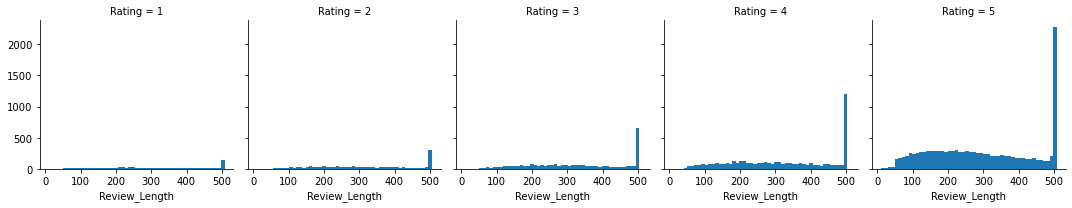

In [35]:
# check if there's any relation between rating and review length
df['Review_Text']=df['Review_Text'].astype(str)
df['Review_Length']=df['Review_Text'].apply(len)
g = sns.FacetGrid(data=df, col='Rating')
g.map(plt.hist, 'Review_Length', bins=50)


Text(0.5, 1.0, 'Count of Ratings')

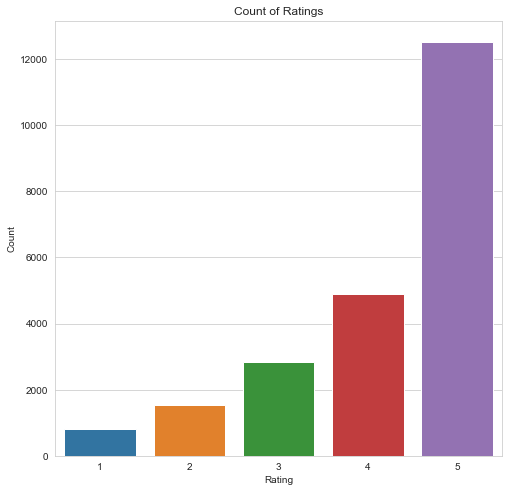

In [25]:
z=df.groupby(by=['Rating'],as_index=False).count().sort_values(by='Class_Name',ascending=False)

plt.figure(figsize=(8,8))
sns.set_style("whitegrid")
ax = sns.barplot(x=z['Rating'],y=z['Class_Name'], data=z)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Ratings")


In [6]:
# data cleaning

# removal of punctuation 
string.punctuation
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str
cleaneddata = df.copy()
cleaneddata['Review_Text'] = cleaneddata['Review_Text'].apply(punctuation_removal)
cleaneddata['Review_Text'].head()


0    Absolutely wonderful  silky and sexy and comfo...
1    Love this dress  its sooo pretty  i happened t...
2    I had such high hopes for this dress and reall...
3    I love love love this jumpsuit its fun flirty ...
4    This shirt is very flattering to all due to th...
Name: Review_Text, dtype: object

In [7]:
# removing stopwords

stop = stopwords.words('english')
stop_words = []

# remove punctuation in stopwords
for item in stop: 
    new_item = punctuation_removal(item)
    stop_words.append(new_item) 

# adding a list of words related to clothing to the stopwords
clothes_list =['dress', 'top','sweater','shirt',
               'skirt','material', 'white', 'black',
              'jeans', 'fabric', 'color','order', 'wear']

def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str 
            if word.lower() not in stop_words and word.lower() not in clothes_list ]

cleaneddata['Review_Text'] = cleaneddata['Review_Text'].apply(stopwords_removal)
cleaneddata['Review_Text'].head()


0    [absolutely, wonderful, silky, sexy, comfortable]
1    [love, sooo, pretty, happened, find, store, im...
2    [high, hopes, really, wanted, work, initially,...
3    [love, love, love, jumpsuit, fun, flirty, fabu...
4    [flattering, due, adjustable, front, tie, perf...
Name: Review_Text, dtype: object

In [8]:
# removing numbers
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

cleaneddata['Review_Text'] = cleaneddata['Review_Text'].apply(drop_numbers)
cleaneddata['Review_Text'].head()

0          absolutely wonderful silky sexy comfortable
1    love sooo pretty happened find store im glad b...
2    high hopes really wanted work initially ordere...
3    love love love jumpsuit fun flirty fabulous ev...
4    flattering due adjustable front tie perfect le...
Name: Review_Text, dtype: object

In [9]:
# stemming

porter = PorterStemmer()

cleaneddata['Review_Text'] = cleaneddata['Review_Text'].apply(lambda x: x.split())

def stem_update(text_list):
    text_list_new = []
    for word in text_list:
        word = porter.stem(word)
        text_list_new.append(word) 
    return text_list_new

cleaneddata['Review_Text'] = cleaneddata['Review_Text'].apply(stem_update)
cleaneddata['Review_Text'] = cleaneddata['Review_Text'].apply(lambda x: ' '.join(x))
cleaneddata['Review_Text'].head()

0                    absolut wonder silki sexi comfort
1    love sooo pretti happen find store im glad bc ...
2    high hope realli want work initi order petit s...
3    love love love jumpsuit fun flirti fabul everi...
4    flatter due adjust front tie perfect length le...
Name: Review_Text, dtype: object

In [65]:
pos_df = cleaneddata[cleaneddata.Recommended_IND== 1]
neg_df = cleaneddata[cleaneddata.Recommended_IND== 0]
pos_df.head(3)

,Age,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name,polarity,Polarity,Review_Length
0,33,absolut wonder silki sexi comfort,4,1,0,Initmates,Intimate,Intimates,0.633333,0.633333,53
1,34,love sooo pretti happen find store im glad bc ...,5,1,4,General,Dresses,Dresses,0.339583,0.339583,303
3,50,love love love jumpsuit fun flirti fabul everi...,5,1,0,General Petite,Bottoms,Pants,0.550000,0.550000,124


In [13]:
pos_words =[]
neg_words = []

for review in pos_df.Review_Text:
    pos_words.append(review) 
pos_words = ' '.join(pos_words)


for review in neg_df.Review_Text:
    neg_words.append(review)
neg_words = ' '.join(neg_words)


NameError: name 'pos_df' is not defined

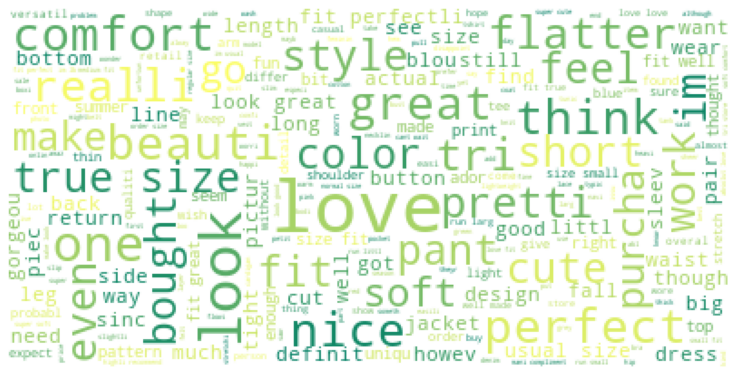

In [67]:
wordcloud = WordCloud().generate(pos_words)

wordcloud = WordCloud(background_color="white",max_words=len(pos_words),\
                      max_font_size=40, relative_scaling=.5, colormap='summer').generate(pos_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

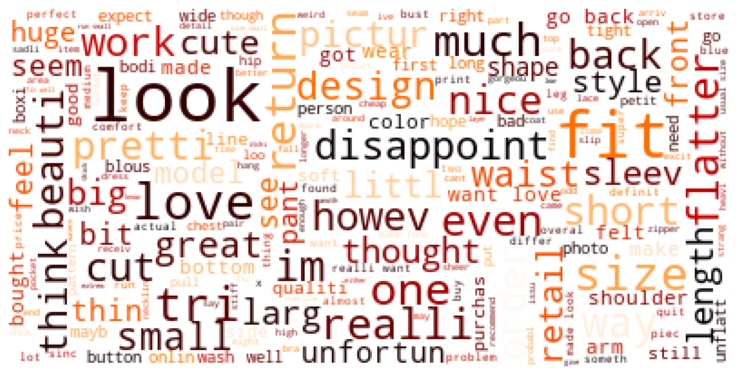

In [68]:
wordcloud = WordCloud().generate(neg_words)

wordcloud = WordCloud(background_color="white",max_words=len(neg_words),\
                      max_font_size=40, relative_scaling=.5, colormap='gist_heat').generate(neg_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [10]:
# vectorizing - bag of words

def text_vectorizing_process(sentence_string):
    return [word for word in sentence_string.split()]

bow_transformer = CountVectorizer(text_vectorizing_process)

bow_transformer.fit(cleaneddata['Review_Text'])
bowreview = bow_transformer.transform(cleaneddata['Review_Text'])
bowreview


/Users/corina/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass input=<function text_vectorizing_process at 0x7ff8fb6e5af0> as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


<22641x13759 sparse matrix of type '<class 'numpy.int64'>'
	with 541226 stored elements in Compressed Sparse Row format>

In [68]:
print('Shape of Sparse Matrix', bowreview.shape)
print('Amount of Non-Zero occurences:', bowreview.nnz)


Shape of Sparse Matrix (22641, 13759)
Amount of Non-Zero occurences: 541226


In [11]:
# vectorizing - tf-idf

# def text_vectorizing_process(sentence_string):
#     return [word for word in sentence_string.split()]

# tfidf_transformer = TfidfTransformer(text_vectorizing_process)
# tfidf_transformer.fit(cleaneddata['Review_Text'])
# tfidfreview = tfidf_transformer.transform(cleaneddata['Review_Text'])
# tfidfreview.shape
# tfidfreview.nnz


tfidf_transformer = TfidfTransformer().fit(bowreview)
tfidfreview = tfidf_transformer.transform(bowreview)
print('Shape of Sparse Matrix', tfidfreview.shape)
print('Amount of Non-Zero occurences:', tfidfreview.nnz)

Shape of Sparse Matrix (22641, 13759)
Amount of Non-Zero occurences: 541226


In [12]:
# Merging Sparse matrix with other features
tfidfreview = tfidfreview.toarray()
tfidfreview = pd.DataFrame(tfidfreview)
df_all = pd.merge(cleaneddata.drop(columns=['Review_Text','Age','Positive_Feedback_Count','Division_Name','Class_Name','Department_Name']),tfidfreview, 
                  left_index=True, right_index=True )
df_all.head(10)

,Rating,Recommended_IND,Polarity,0,1,2,3,4,5,6,...,13749,13750,13751,13752,13753,13754,13755,13756,13757,13758
0,4,1,0.633333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5,1,0.339583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,0.073675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.132227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5,1,0.550000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1,0.512891,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2,0,0.178750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,5,1,0.133750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4,1,0.171635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,5,1,0.002500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,5,1,0.204200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
# splitting the data

X = df_all.drop('Recommended_IND', axis=1)
y = df_all.Recommended_IND

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)


In [15]:
#normalize the data

y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
pd.DataFrame(X_train_scaled,columns= X_train.columns).describe()

,Rating,Polarity,0,1,2,3,4,5,6,7,...,13749,13750,13751,13752,13753,13754,13755,13756,13757,13758
count,17455.000000,17455.000000,17455.000000,17455.000000,17455.000000,17455.0,17455.000000,17455.000000,17455.000000,17455.0,...,17455.000000,17455.0,17455.000000,17455.0,17455.000000,17455.000000,17455.000000,17455.000000,17455.0,17455.000000
mean,0.797250,0.620723,0.000142,0.000057,0.000057,0.0,0.000057,0.000057,0.000057,0.0,...,0.005393,0.0,0.000057,0.0,0.000057,0.000207,0.000057,0.000271,0.0,0.000057
std,0.278996,0.089522,0.010920,0.007569,0.007569,0.0,0.007569,0.007569,0.007569,0.0,...,0.046738,0.0,0.007569,0.0,0.007569,0.012547,0.007569,0.014748,0.0,0.007569
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.750000,0.564949,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,1.000000,0.615190,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,1.000000,0.671446,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,...,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000


In [17]:
def report(y_true, y_pred, labels):
    cm = pd.DataFrame(confusion_matrix(y_true=y_true, y_pred=y_pred), 
                                        index=labels, columns=labels)
    rep = classification_report(y_true=y_true, y_pred=y_pred)
    return (f'Confusion Matrix:\n{cm}\n\nClassification Report:\n{rep}')

In [37]:
classifier = MultinomialNB()
classifier.fit(X_train_scaled, y_train)

MultinomialNB()

In [43]:
test_predictions = classifier.predict(X_test_scaled)
print(report(y_test, test_predictions, classifier.classes_ ))

# y_pred = classifier.predict(X_test_scaled)
# acc = accuracy_score(y_test, y_pred)
# acc

Confusion Matrix:
    0     1
0   6   812
1  30  3516

Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.01      0.01       818
           1       0.81      0.99      0.89      3546

    accuracy                           0.81      4364
   macro avg       0.49      0.50      0.45      4364
weighted avg       0.69      0.81      0.73      4364



In [23]:
svc_model = LinearSVC(C=1.0, 
             class_weight='balanced', 
             random_state=111)
svc_model.fit(X_train_scaled, y_train)

LinearSVC(class_weight='balanced', random_state=111)

In [24]:
test_predictions1 = svc_model.predict(X_test_scaled)
print(report(y_test, test_predictions1, svc_model.classes_ ))

Confusion Matrix:
     0     1
0  652   166
1  219  3327

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77       818
           1       0.95      0.94      0.95      3546

    accuracy                           0.91      4364
   macro avg       0.85      0.87      0.86      4364
weighted avg       0.91      0.91      0.91      4364



In [20]:
lr_model = LogisticRegression(class_weight='balanced', 
                              random_state=111, 
                              solver='lbfgs',
                              C=1.0)

gs_lr_model = GridSearchCV(lr_model, 
                           param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, 
                           cv=5, 
                           scoring='roc_auc')

gs_lr_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=111),
             param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, scoring='roc_auc')

In [21]:
test_predictions2 = gs_lr_model.predict(X_test_scaled)
print(report(y_test, test_predictions2, gs_lr_model.classes_ ))

Confusion Matrix:
     0     1
0  775    43
1  254  3292

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       818
           1       0.99      0.93      0.96      3546

    accuracy                           0.93      4364
   macro avg       0.87      0.94      0.90      4364
weighted avg       0.94      0.93      0.93      4364



In [18]:
bernoulli_model = BernoulliNB()
bernoulli_model.fit(X_train_scaled, y_train)

BernoulliNB()

In [19]:
test_predictions3 = bernoulli_model.predict(X_test_scaled)
print(report(y_test, test_predictions3, bernoulli_model.classes_ ))

# y_pred = classifier.predict(X_test)
# from sklearn.metrics import accuracy_score
# acc = accuracy_score(y_test, y_pred)

Confusion Matrix:
     0     1
0  187   631
1  181  3365

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.23      0.32       818
           1       0.84      0.95      0.89      3546

    accuracy                           0.81      4364
   macro avg       0.68      0.59      0.60      4364
weighted avg       0.78      0.81      0.78      4364



In [13]:
X = df_all.drop('Recommended_IND', axis=1)
y = df_all.Recommended_IND

oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)


In [14]:
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
pd.DataFrame(X_train_scaled,columns= X_train.columns).describe()

,Rating,Polarity,0,1,2,3,4,5,6,7,...,13749,13750,13751,13752,13753,13754,13755,13756,13757,13758
count,28592.000000,28592.000000,28592.000000,28592.000000,28592.000000,28592.000000,28592.000000,28592.000000,28592.000000,28592.0,...,28592.000000,28592.000000,28592.000000,28592.000000,28592.000000,28592.000000,28592.0,28592.000000,28592.000000,28592.000000
mean,0.612899,0.596897,0.000069,0.000035,0.000035,0.000035,0.000045,0.000035,0.000035,0.0,...,0.004984,0.000035,0.000064,0.000035,0.000035,0.000308,0.0,0.000269,0.000035,0.000035
std,0.343496,0.088402,0.008283,0.005914,0.005914,0.005914,0.006140,0.005914,0.005914,0.0,...,0.042329,0.005914,0.007700,0.005914,0.005914,0.013723,0.0,0.014129,0.005914,0.005914
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.250000,0.542752,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,0.500000,0.591831,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
75%,1.000000,0.646553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000


In [15]:
classifier = MultinomialNB()
classifier.fit(X_train_scaled, y_train)

MultinomialNB()

In [18]:
test_predictions = classifier.predict(X_test_scaled)
print(report(y_test, test_predictions, classifier.classes_ ))

# y_pred = classifier.predict(X_test_scaled)
# acc = accuracy_score(y_test, y_pred)
# acc

Confusion Matrix:
      0     1
0  3247   336
1   820  2745

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85      3583
           1       0.89      0.77      0.83      3565

    accuracy                           0.84      7148
   macro avg       0.84      0.84      0.84      7148
weighted avg       0.84      0.84      0.84      7148



In [23]:
svc_model = LinearSVC(C=1.0, 
             class_weight='balanced', 
             random_state=111)
svc_model.fit(X_train_scaled, y_train)

LinearSVC(class_weight='balanced', random_state=111)

In [24]:
test_predictions1 = svc_model.predict(X_test_scaled)
print(report(y_test, test_predictions1, svc_model.classes_ ))

Confusion Matrix:
      0     1
0  3547    36
1   240  3325

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3583
           1       0.99      0.93      0.96      3565

    accuracy                           0.96      7148
   macro avg       0.96      0.96      0.96      7148
weighted avg       0.96      0.96      0.96      7148



In [21]:
lr_model = LogisticRegression(class_weight='balanced', 
                              random_state=111, 
                              solver='lbfgs',
                              C=1.0)

gs_lr_model = GridSearchCV(lr_model, 
                           param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, 
                           cv=5, 
                           scoring='roc_auc')

gs_lr_model.fit(X_train_scaled, y_train)

/Users/corina/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=111),
             param_grid={'C': [0.01, 0.1, 0.5, 1.0, 5.0]}, scoring='roc_auc')

In [22]:
test_predictions2 = gs_lr_model.predict(X_test_scaled)
print(report(y_test, test_predictions2, gs_lr_model.classes_ ))

Confusion Matrix:
      0     1
0  3540    43
1   232  3333

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3583
           1       0.99      0.93      0.96      3565

    accuracy                           0.96      7148
   macro avg       0.96      0.96      0.96      7148
weighted avg       0.96      0.96      0.96      7148



In [19]:
bernoulli_model = BernoulliNB()
bernoulli_model.fit(X_train_scaled, y_train)

BernoulliNB()

In [20]:
test_predictions3 = bernoulli_model.predict(X_test_scaled)
print(report(y_test, test_predictions3, bernoulli_model.classes_ ))

# y_pred = classifier.predict(X_test)
# from sklearn.metrics import accuracy_score
# acc = accuracy_score(y_test, y_pred)

Confusion Matrix:
      0     1
0  2542  1041
1   844  2721

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      3583
           1       0.72      0.76      0.74      3565

    accuracy                           0.74      7148
   macro avg       0.74      0.74      0.74      7148
weighted avg       0.74      0.74      0.74      7148

